In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.densenet import DenseNet201
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load In the Dataset

In [3]:
X_train = np.load("/floyd/input/skin_cancer_192_256/256_192_train.npy")

In [4]:
y_train = np.load("/floyd/input/skin_cancer_192_256/train_labels.npy")

In [5]:
X_val = np.load("/floyd/input/skin_cancer_192_256/256_192_val.npy")

In [6]:
y_val = np.load("/floyd/input/skin_cancer_192_256/val_labels.npy")

In [7]:
X_train.shape, X_val.shape

((8111, 192, 256, 3), (902, 192, 256, 3))

In [8]:
y_train.shape, y_val.shape

((8111,), (902,))

In [9]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [10]:
y_train.shape, y_val.shape

((8111, 7), (902, 7))

## Load In the Model

In [11]:
pre_trained_model = DenseNet201(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

74842112/74836368 [==============================] - 4s 0us/step


In [12]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
zero_padding2d_1
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_2
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3

In [13]:
last_layer = pre_trained_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 1920)


## Define the Model

In [14]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.7
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

## Training

### Feature Extraction

In [16]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [17]:
batch_size = 32
epochs = 3
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))

Epoch 1/3
253/253 [==============================] - 107s 422ms/step - loss: 1.6905 - acc: 0.6123 - val_loss: 1.5058 - val_acc: 0.6663
Epoch 2/3
253/253 [==============================] - 97s 385ms/step - loss: 0.9679 - acc: 0.6793 - val_loss: 1.6497 - val_acc: 0.6724
Epoch 3/3
253/253 [==============================] - 95s 376ms/step - loss: 0.9138 - acc: 0.6872 - val_loss: 1.8726 - val_acc: 0.6621


### Retraining

In [18]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [19]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 198, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 96, 128, 64)  9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 96, 128, 64)  256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [22]:
batch_size = 32
epochs = 20
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/20
253/253 [==============================] - 384s 2s/step - loss: 0.7455 - acc: 0.7386 - val_loss: 0.8257 - val_acc: 0.7232
Epoch 2/20
253/253 [==============================] - 337s 1s/step - loss: 0.5644 - acc: 0.7980 - val_loss: 0.5695 - val_acc: 0.8126
Epoch 3/20
253/253 [==============================] - 335s 1s/step - loss: 0.4717 - acc: 0.8305 - val_loss: 0.6038 - val_acc: 0.7954
Epoch 4/20
253/253 [==============================] - 334s 1s/step - loss: 0.3995 - acc: 0.8620 - val_loss: 0.6201 - val_acc: 0.7793
Epoch 5/20
253/253 [==============================] - 333s 1s/step - loss: 0.3614 - acc: 0.8704 - val_loss: 0.4384 - val_acc: 0.8425
Epoch 6/20
253/253 [==============================] - 333s 1s/step - loss: 0.3287 - acc: 0.8809 - val_loss: 0.6623 - val_acc: 0.7966
Epoch 7/20
253/253 [==============================] - 333s 1s/step - loss: 0.2892 - acc: 0.8975 - val_loss: 0.5001 - val_acc: 0.8402
Epoch 8/20
253/253 [==============================] - 333s 1s/step - 

In [23]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

902/902 [==============================] - 11s 12ms/step
Validation: accuracy = 0.866962  ;  loss_v = 0.626969


## Testing

In [24]:
X_test = np.load("/floyd/input/skin_cancer_192_256/256_192_test.npy")

In [25]:
y_test = np.load("/floyd/input/skin_cancer_192_256/test_labels.npy")
y_test = to_categorical(y_test)

In [26]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

1002/1002 [==============================] - 13s 13ms/step
Test: accuracy = 0.877246  ;  loss = 0.558797


In [27]:
model.save("DenseNetFull.h5")

Text(0.5,1,'Training and validation loss')

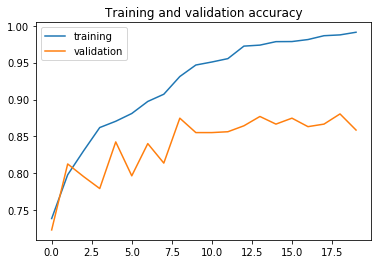

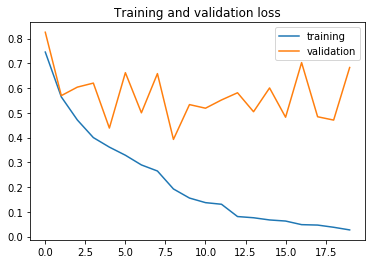

In [28]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')